# Load data

In [18]:
#from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from itertools import combinations_with_replacement

#upload = files.upload()
data_train = pd.read_csv("data_X.csv")
data_target = pd.read_csv("data_T.csv")
data_train = data_train.to_numpy()
data_target = data_target.to_numpy()

Saving data_T.csv to data_T (1).csv
Saving data_X.csv to data_X (1).csv


In [19]:
x = np.empty([400, 1], dtype=float)
y = np.empty([100, 1], dtype=float)
x = data_train[:, 1:]
y = data_target[:, 1:]
train_x = x[ :400, : ]
train_y = y[ :400, : ]
valid_x = x[400: , : ]
valid_y = y[400: , : ]
#print(x.shape)

# 1. Feature select
max_likelihood: 使用 Maximum Likelihood approach 計算出 w

RMS_error: 計算 RMS error, RMS error = $\sqrt{2E(w^*)/N}$

calculate_basis: 計算不同 order 的 polynomial basis


In [20]:
def max_likelihood(phi, t):
  a = np.dot(phi.transpose(), phi)
  #det = np.linalg.det(a)
  #print(det)
  a = np.linalg.pinv(a)
  b = np.dot(a, phi.transpose())
  return np.dot(b, t)

def RMS_error(x, w, t):
  return np.sqrt( np.sum( np.power(np.dot(x, w) - t, 2) )/x.shape[0] )

def calculate_basis(x, order):
  basis = x
  basis = np.concatenate( (np.ones([x.shape[0],1]), basis), axis=1 ).astype(float)
  for i in range(1, order):
    for j in list(combinations_with_replacement(range(1, 8), order)):
      y = np.prod(basis[:, j], axis=1).reshape((basis.shape[0], 1))
      basis = np.concatenate( (basis, y), axis=1 )
  return basis


## 1.(a) Apply polynomials of order M=1, 2 and evaluate RMS error

### Polynomial (order M = 1)
$y(x,w) =w_0+\sum^D_{i=1}w_ix_i \\
w_{ML} = (\Phi^T \Phi)^{-1}\Phi^Tt$

train1_x矩陣代表order=1下的 $\Phi$


In [21]:
train1_x = calculate_basis(train_x, 1)
valid1_x = calculate_basis(valid_x, 1)
w1 = max_likelihood(train1_x, train_y)
#print(w1)

train1_error = RMS_error(train1_x, w1, train_y)
valid1_error = RMS_error(valid1_x, w1, valid_y)

print("Order M = 1")
print("training error:", train1_error)
print("validation error:", valid1_error)

Order M = 1
training error: 0.06314185017282051
validation error: 0.04293220746210822


### Polynomial (order M = 2)
$y(x,w) =w_0+\sum^D_{i=1}w_ix_i+\sum^D_{i=1}\sum^D_{j=1}w_{ij}x_ix_j$

因為$x_ix_j$和$x_jx_i$相同，所以當成同一項合併計算

總共有$w_0 \sim w_7, w_{11}, w_{12}, ... w_{66}, w_{67}, w_{77}$ 36個

$w_{ML} = (\Phi^T \Phi)^{-1}\Phi^Tt$

train2_x矩陣代表order=2下的 $\Phi$

In [22]:
train2_x = calculate_basis(train_x, 2)
valid2_x = calculate_basis(valid_x, 2)

w2 = max_likelihood(train2_x, train_y)
#print(w2)

train2_error = RMS_error(train2_x, w2, train_y)
valid2_error = RMS_error(valid2_x, w2, valid_y)

print("Order M = 2")
print("training error:", train2_error)
print("validation error:", valid2_error)

Order M = 2
training error: 0.060156948388800945
validation error: 0.0489452758900997


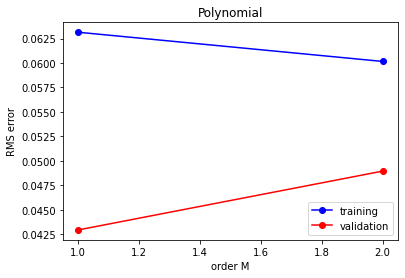

Order M = 1, training error: 0.06314185017282051 , validation error: 0.04293220746210822
Order M = 2, training error: 0.060156948388800945 , validation error: 0.0489452758900997


In [23]:
plt.plot([1, 2],[train1_error, train2_error], '-bo', label='training')
plt.plot([1, 2],[valid1_error, valid2_error], '-ro', label='validation')
plt.title('Polynomial')
plt.xlabel('order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

print("Order M = 1, training error:", train1_error, ", validation error:", valid1_error)
print("Order M = 2, training error:", train2_error, ", validation error:", valid2_error)

## Select the most contributive feature
每次去掉一個 feature，並計算 RMS error，去掉後error 最大的代表那個 feature 最 contributive

根據下方的計算，the most contributive feature 是 **CGPA**


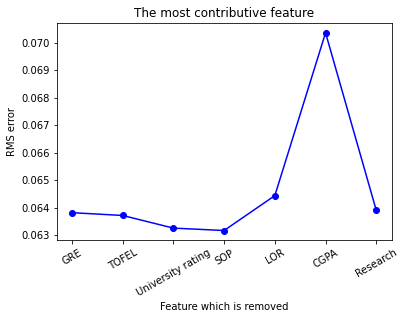

training error: 0.06381829679381827 	, GRE is removed
training error: 0.06371753663473695 	, TOFEL is removed
training error: 0.0632574013178459 	, University rating is removed
training error: 0.06317028722316699 	, SOP is removed
training error: 0.06443899165693005 	, LOR is removed
training error: 0.07035976310693098 	, CGPA is removed
training error: 0.06390185725541248 	, Research is removed


In [24]:
feature_name = ['GRE', 'TOFEL', 'University rating', 'SOP', 'LOR', 'CGPA', 'Research']
feature_error = []
for i in range(7):
  feature = np.concatenate((train1_x[:, :i+1], train1_x[:, i+2:]), axis=1)
  w = max_likelihood(feature, train_y)
  feature_error.append(RMS_error(feature, w, train_y))


plt.plot(feature_name, feature_error, '-bo')
plt.title('The most contributive feature')
plt.xlabel('Feature which is removed')
plt.ylabel('RMS error')
plt.xticks(rotation=30)
plt.show()

for i in range(7):
  print("training error:", feature_error[i], "\t,", feature_name[i], "is removed")

# 2. Maximum likelihood approach

## 2.(a) Choose a basis function
我分別計算了 Polynomial, Gaussian, Sigmoidal 三種 basis function 
的 RMS error

發現 Polynomial 的 RMS error 最小，所以我選用了 Polynomial 來當作
basis function

### Gaussian distribution
$ \phi_j(x) = exp \{-\frac{(x-\mu_j)^2}{2s^2}\}\\ 
\mu_{ML} = \frac{1}{N}\sum^N_{n=1}x_n, \quad\sigma^2_{ML} = \frac{1}{N}\sum^N_{n=1}(x_n-\mu_{ML})^2 $

In [ ]:
# training
gaussian_basis_t = np.ones([400,8])
mean_t = np.mean(train1_x, axis=0)
var_t = np.var(train1_x, axis=0)

for i in range(400):
  for j in range(1,8):
    gaussian_basis_t[i,j] = np.exp(-1 * (train1_x[i,j] - mean_t[j])**2 / (2 * var_t[j]))

# validation
gaussian_basis_v = np.ones([100,8])
mean_v = np.mean(valid1_x, axis=0)
var_v = np.var(valid1_x, axis=0)

for i in range(100):
  for j in range(1,8):
    gaussian_basis_v[i,j] = np.exp(-1 * (valid1_x[i,j] - mean_v[j])**2 / (2 * var_v[j]))

w_gaussian = max_likelihood(gaussian_basis_t, train_y)

print("Gaussian")
print("training error:", RMS_error(gaussian_basis_t, w_gaussian, train_y))
print("validation error:", RMS_error(gaussian_basis_v, w_gaussian, valid_y))



Gaussian
training error: 0.11759710754974717
validation error: 0.1600590986173842


### Sigmoidal
$ \phi_j(x) = \sigma(\frac{x-\mu_j}{s})\quad $where$ \quad\sigma(a) = \frac{1}{1+exp(-a)}$

In [26]:
# training
sigmoidal_basis_t = np.ones([400,8])
std_t = np.std(train1_x, axis=0)

for i in range(400):
  for j in range(1,8):
    sigmoidal_basis_t[i, j] = 1 / (1 + np.exp((mean_t[j]-train1_x[i, j]) / std_t[j]))
#print(sigmoidal_basis)

# validation
sigmoidal_basis_v = np.ones([100,8])
std_v = np.std(valid1_x, axis=0)

for i in range(100):
  for j in range(1,8):
    sigmoidal_basis_v[i, j] = 1 / (1 + np.exp((mean_v[j]-valid1_x[i, j]) / std_v[j]))

w_sigmoidal = max_likelihood(sigmoidal_basis_t, train_y)

print("Sigmoidal")
print("training error:", RMS_error(sigmoidal_basis_t, w_sigmoidal, train_y))
print("validation error:", RMS_error(sigmoidal_basis_v, w_sigmoidal, valid_y))

Sigmoidal
training error: 0.06400098313961106
validation error: 0.046964913552879364


## 2.(b) basis function




### Polynomial basis function

In [28]:
ML_train_error = [train1_error, train2_error]
ML_valid_error = [valid1_error, valid2_error]

for i in range(3,6):
  trainM_x = calculate_basis(train_x, i)
  validM_x = calculate_basis(valid_x, i)
  wM = max_likelihood(trainM_x, train_y)
  trainM_error = RMS_error(trainM_x, wM, train_y)
  validM_error = RMS_error(validM_x, wM, valid_y)
  ML_train_error.append(trainM_error)
  ML_valid_error.append(validM_error)
  #print(wM)


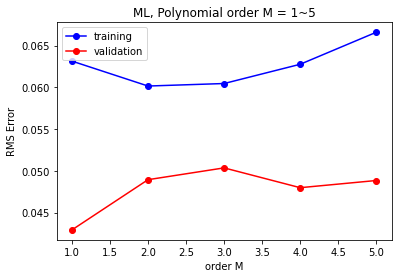

Order M =  1 , training error: 0.06314185017282051 , validation error: 0.04293220746210822
Order M =  2 , training error: 0.060156948388800945 , validation error: 0.0489452758900997
Order M =  3 , training error: 0.06045733339457231 , validation error: 0.050357918149964424
Order M =  4 , training error: 0.0627622017847954 , validation error: 0.047987544765625056
Order M =  5 , training error: 0.06659600860562831 , validation error: 0.04884755280707127
Avg training error: 0.0626228684693235 , Avg validation error: 0.04781409981497373


In [29]:
plt.plot(range(1,6),ML_train_error, '-bo', label='training')
plt.plot(range(1,6),ML_valid_error, '-ro', label='validation')
plt.title('ML, Polynomial order M = 1~5')
plt.xlabel('order M')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", training error:", ML_train_error[i-1], ", validation error:", ML_valid_error[i-1])

print("Avg training error:", np.mean(ML_train_error), ", Avg validation error:", np.mean(ML_valid_error))

### Sigmoidal basis function

In [30]:
def sigmoidal(x):
  a = x
  for i in range(x.shape[0]):
    for j in range(1, x.shape[1]):
      a[i, j] = 1 / (1 + np.exp((np.mean(x[:, j])-x[i, j]) / np.std(x[:, j])))
  return a

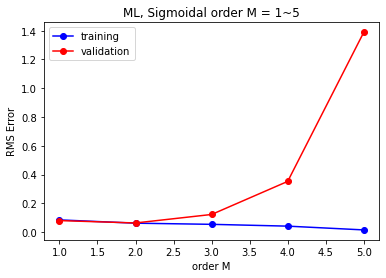

Order M =  1 , training error: 0.08439978612817416 , validation error: 0.07946096593969662
Order M =  2 , training error: 0.0614998326158999 , validation error: 0.06303110999360853
Order M =  3 , training error: 0.05349894242289513 , validation error: 0.1220757458833037
Order M =  4 , training error: 0.040908838533858925 , validation error: 0.35205336201049364
Order M =  5 , training error: 0.01466209992368184 , validation error: 1.389306776217288
Avg training error: 0.050993899924902 , Avg validation error: 0.4011855920088781


In [31]:
ML_train_error = []
ML_valid_error = []
for i in range(1,6):
  trainM_x = calculate_basis(train_x, i)
  validM_x = calculate_basis(valid_x, i)
  trainM_x = sigmoidal(trainM_x)
  validM_x = sigmoidal(validM_x)
  wM = max_likelihood(trainM_x, train_y)
  trainM_error = RMS_error(trainM_x, wM, train_y)
  validM_error = RMS_error(validM_x, wM, valid_y)
  ML_train_error.append(trainM_error)
  ML_valid_error.append(validM_error)

plt.plot(range(1,6),ML_train_error, '-bo', label='training')
plt.plot(range(1,6),ML_valid_error, '-ro', label='validation')
plt.title('ML, Sigmoidal order M = 1~5')
plt.xlabel('order M')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", training error:", ML_train_error[i-1], ", validation error:", ML_valid_error[i-1])

print("Avg training error:", np.mean(ML_train_error), ", Avg validation error:", np.mean(ML_valid_error))

## 2.(c) N-fold cross-validation
N=5，hyperparameter 為 order， 把 data 切成 5 等分，
每 1 等分是 100 筆 data，每次挑其中一份當作 validation set
其他當作 training set，算出 order M = 1~5 的 error，再把
5 次在不同 order 下的 training error 和 validation error 取平均


### Polynomial cross-validation

In [32]:
cross_train_error = []
cross_valid_error = []
for i in range(5):
  partial_valid_x = x[i*100:(i+1)*100, :]
  partial_valid_y = y[i*100:(i+1)*100, :]
  partial_train_x = np.concatenate( (x[:i*100, :], x[(i+1)*100:, :]), axis=0)
  partial_train_y = np.concatenate( (y[:i*100, :], y[(i+1)*100:, :]), axis=0)
  train_error_i = []
  valid_error_i = []
  for j in range(5):
    tmp_valid_x = calculate_basis(partial_valid_x, j+1)
    tmp_train_x = calculate_basis(partial_train_x, j+1)
    w_cross_valid = max_likelihood(tmp_train_x, partial_train_y)
    train_error_i.append(RMS_error(tmp_train_x, w_cross_valid, partial_train_y))
    valid_error_i.append(RMS_error(tmp_valid_x, w_cross_valid, partial_valid_y))
  cross_train_error.append(train_error_i)
  cross_valid_error.append(valid_error_i)

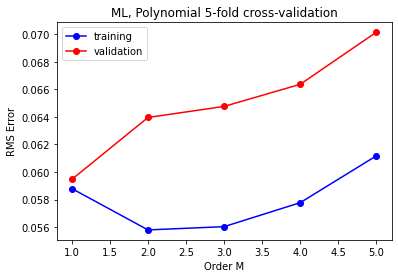

Order M =  1 , Avg training error: 0.058796957934396335 , Avg validation error: 0.05946970564723701
Order M =  2 , Avg training error: 0.055799874989788625 , Avg validation error: 0.06395666923833118
Order M =  3 , Avg training error: 0.05603660552707511 , Avg validation error: 0.06475916692825537
Order M =  4 , Avg training error: 0.057774174777854646 , Avg validation error: 0.06636296270074095
Order M =  5 , Avg training error: 0.061171521079872185 , Avg validation error: 0.0701395069083409


In [33]:
avg_train_error = np.mean(np.array(cross_train_error), axis=0)
avg_valid_error = np.mean(np.array(cross_valid_error), axis=0)

plt.plot(range(1,6), avg_train_error, '-bo', label='training')
plt.plot(range(1,6), avg_valid_error, '-ro', label='validation')
plt.title('ML, Polynomial 5-fold cross-validation')
plt.xlabel('Order M')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", Avg training error:", avg_train_error[i-1], ", Avg validation error:", avg_valid_error[i-1])

### Sigmoidal cross-validation

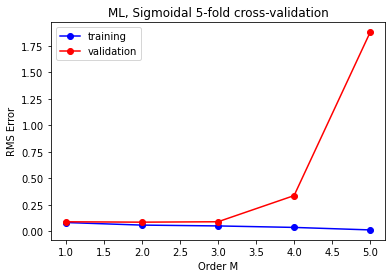

Order M =  1 , Avg training error: 0.08438620839192451 , Avg validation error: 0.09147956618308255
Order M =  2 , Avg training error: 0.06012104250228868 , Avg validation error: 0.08776071231712508
Order M =  3 , Avg training error: 0.05225479086365459 , Avg validation error: 0.09161315843609374
Order M =  4 , Avg training error: 0.03819260940640811 , Avg validation error: 0.3383204734597142
Order M =  5 , Avg training error: 0.014631824824882414 , Avg validation error: 1.8797237350077165


In [34]:
cross_train_error = []
cross_valid_error = []
for i in range(5):
  partial_valid_x = x[i*100:(i+1)*100, :]
  partial_valid_y = y[i*100:(i+1)*100, :]
  partial_train_x = np.concatenate( (x[:i*100, :], x[(i+1)*100:, :]), axis=0)
  partial_train_y = np.concatenate( (y[:i*100, :], y[(i+1)*100:, :]), axis=0)
  train_error_i = []
  valid_error_i = []
  for j in range(5):
    tmp_valid_x = calculate_basis(partial_valid_x, j+1)
    tmp_train_x = calculate_basis(partial_train_x, j+1)
    tmp_valid_x = sigmoidal(tmp_valid_x)
    tmp_train_x = sigmoidal(tmp_train_x)
    w_cross_valid = max_likelihood(tmp_train_x, partial_train_y)
    train_error_i.append(RMS_error(tmp_train_x, w_cross_valid, partial_train_y))
    valid_error_i.append(RMS_error(tmp_valid_x, w_cross_valid, partial_valid_y))
  cross_train_error.append(train_error_i)
  cross_valid_error.append(valid_error_i)

avg_train_error = np.mean(np.array(cross_train_error), axis=0)
avg_valid_error = np.mean(np.array(cross_valid_error), axis=0)

plt.plot(range(1,6), avg_train_error, '-bo', label='training')
plt.plot(range(1,6), avg_valid_error, '-ro', label='validation')
plt.title('ML, Sigmoidal 5-fold cross-validation')
plt.xlabel('Order M')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", Avg training error:", avg_train_error[i-1], ", Avg validation error:", avg_valid_error[i-1])

# 3. Maximum a posterior

minimizing $\frac{\beta}{2}\sum^{N}_{n=1}\{y(x_n,w) - t_n\}^2 + \frac{\alpha}{2}w^Tw$ which is the same as minimizing the regularized sum-of-squares error fumction where $\lambda = \frac{\alpha}{\beta}$

$w = (\lambda I + \Phi^T\Phi)^{-1}\Phi^Tt$

I use $\alpha=1, \beta^{-1}= \frac{1}{N}\sum^N_{n=1}\{y(x_n, w_{ML})-t_n\}^2$

Error function:

$\tilde E(w)=\frac{1}{2}\sum^N_{n=1}\{y(x_n, w)-t_n\}^2 + \frac{\lambda}{2}\|w\|^2 \quad$ where $\quad \|w\|^2 = w^Tw$

In [41]:
def max_a_posterior(phi, t, lambda_MAP):
  a = np.dot(phi.transpose(), phi)
  a = lambda_MAP * np.identity(phi.shape[1]) + a
  a = np.linalg.pinv(a)
  b = np.dot(a, phi.transpose())
  return np.dot(b, t)

## Polynomial

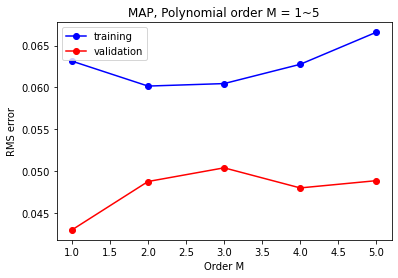

Order M =  1 , training error: 0.06314369675512742 , validation error: 0.04296267816256554
Order M =  2 , training error: 0.060160703172361225 , validation error: 0.048750014607025195
Order M =  3 , training error: 0.060457327704494246 , validation error: 0.05038560236897829
Order M =  4 , training error: 0.06276152202460218 , validation error: 0.047983676873209216
Order M =  5 , training error: 0.06659594325115241 , validation error: 0.04885052669260186
Avg training error: 0.06262383858154749 , Avg validation error: 0.04778649974087602


In [36]:
MAP_train_error = []
MAP_valid_error = []
for i in range(5):
  trainM_x = calculate_basis(train_x, i+1)
  validM_x = calculate_basis(valid_x, i+1)
  w_ML = max_likelihood(trainM_x, train_y)
  beta_inv = np.sum( np.power(np.dot(trainM_x, w_ML)-train_y, 2) )/400
  #pirnt(beta_inv)
  w_MAP = max_a_posterior(trainM_x, train_y, beta_inv)
  MAP_train_error.append(RMS_error(trainM_x, w_MAP, train_y))
  MAP_valid_error.append(RMS_error(validM_x, w_MAP, valid_y))

plt.plot(range(1,6), MAP_train_error, '-bo', label='training')
plt.plot(range(1,6), MAP_valid_error, '-ro', label='validation')
plt.title('MAP, Polynomial order M = 1~5')
plt.xlabel('Order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", training error:", MAP_train_error[i-1], ", validation error:", MAP_valid_error[i-1])

print("Avg training error:", np.mean(MAP_train_error), ", Avg validation error:", np.mean(MAP_valid_error))

### N-fold cross-validation for MAP approach
和 Maximum likelihood 相同的做法，同樣切成 5 等分

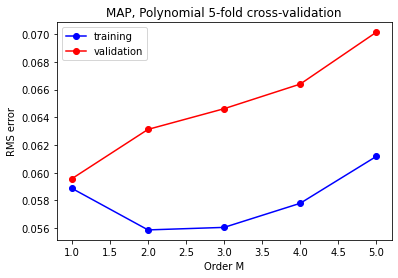

Order M =  1 , Avg training error: 0.05886534655768666 , Avg validation error: 0.05956613028413064
Order M =  2 , Avg training error: 0.0558643592269618 , Avg validation error: 0.0631265632372485
Order M =  3 , Avg training error: 0.056047248250550206 , Avg validation error: 0.06462060647554885
Order M =  4 , Avg training error: 0.05778737683848874 , Avg validation error: 0.06639814898440075
Order M =  5 , Avg training error: 0.06117294456162751 , Avg validation error: 0.07014422613999415


In [37]:
cross_train_error = []
cross_valid_error = []
for i in range(5):
  partial_valid_x = x[i*100:(i+1)*100, :]
  partial_valid_y = y[i*100:(i+1)*100, :]
  partial_train_x = np.concatenate( (x[:i*100, :], x[(i+1)*100:, :]), axis=0)
  partial_train_y = np.concatenate( (y[:i*100, :], y[(i+1)*100:, :]), axis=0)
  train_error_i = []
  valid_error_i = []
  for j in range(5):
    tmp_valid_x = calculate_basis(partial_valid_x, j+1)
    tmp_train_x = calculate_basis(partial_train_x, j+1)
    w_cross_valid = max_likelihood(tmp_train_x, partial_train_y)
    beta_inv = np.sum( np.power(np.dot(tmp_train_x, w_cross_valid)-train_y, 2) )/400
    w_cross_valid = max_a_posterior(tmp_train_x, partial_train_y, beta_inv)
    train_error_i.append(RMS_error(tmp_train_x, w_cross_valid, partial_train_y))
    valid_error_i.append(RMS_error(tmp_valid_x, w_cross_valid, partial_valid_y))
  cross_train_error.append(train_error_i)
  cross_valid_error.append(valid_error_i)

avg_train_error = np.mean(np.array(cross_train_error), axis=0)
avg_valid_error = np.mean(np.array(cross_valid_error), axis=0)

plt.plot(range(1,6), avg_train_error, '-bo', label='training')
plt.plot(range(1,6), avg_valid_error, '-ro', label='validation')
plt.title('MAP, Polynomial 5-fold cross-validation')
plt.xlabel('Order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", Avg training error:", avg_train_error[i-1], ", Avg validation error:", avg_valid_error[i-1])

$\lambda$ = 0.3


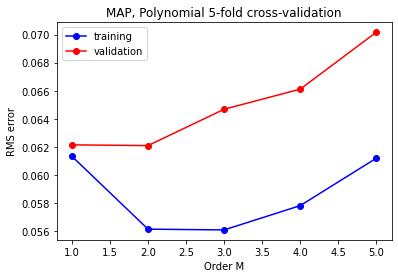

Order M =  1 , Avg training error: 0.06131442222486858 , Avg validation error: 0.0621299018635012
Order M =  2 , Avg training error: 0.05611018041205951 , Avg validation error: 0.06207732509410875
Order M =  3 , Avg training error: 0.056056310443242684 , Avg validation error: 0.06467177267072523
Order M =  4 , Avg training error: 0.057788925530220824 , Avg validation error: 0.06610779853869865
Order M =  5 , Avg training error: 0.06117441431695679 , Avg validation error: 0.07017152911103186


In [38]:
cross_train_error = []
cross_valid_error = []
for i in range(5):
  partial_valid_x = x[i*100:(i+1)*100, :]
  partial_valid_y = y[i*100:(i+1)*100, :]
  partial_train_x = np.concatenate( (x[:i*100, :], x[(i+1)*100:, :]), axis=0)
  partial_train_y = np.concatenate( (y[:i*100, :], y[(i+1)*100:, :]), axis=0)
  train_error_i = []
  valid_error_i = []
  for j in range(5):
    tmp_valid_x = calculate_basis(partial_valid_x, j+1)
    tmp_train_x = calculate_basis(partial_train_x, j+1)
    w_cross_valid = max_a_posterior(tmp_train_x, partial_train_y, 0.3)
    train_error_i.append(RMS_error(tmp_train_x, w_cross_valid, partial_train_y))
    valid_error_i.append(RMS_error(tmp_valid_x, w_cross_valid, partial_valid_y))
  cross_train_error.append(train_error_i)
  cross_valid_error.append(valid_error_i)

avg_train_error = np.mean(np.array(cross_train_error), axis=0)
avg_valid_error = np.mean(np.array(cross_valid_error), axis=0)

plt.plot(range(1,6), avg_train_error, '-bo', label='training')
plt.plot(range(1,6), avg_valid_error, '-ro', label='validation')
plt.title('MAP, Polynomial 5-fold cross-validation')
plt.xlabel('Order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", Avg training error:", avg_train_error[i-1], ", Avg validation error:", avg_valid_error[i-1])

## Sigmoidal

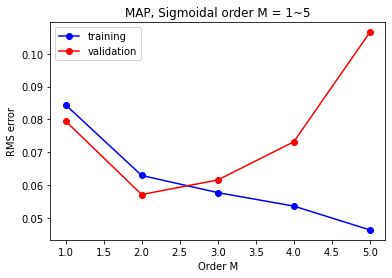

Order M =  1 , training error: 0.08444928028342154 , validation error: 0.07950074290710626
Order M =  2 , training error: 0.06289653777595809 , validation error: 0.05708378856240858
Order M =  3 , training error: 0.05767063781813986 , validation error: 0.061507977511977154
Order M =  4 , training error: 0.0535558090239036 , validation error: 0.07317222701826755
Order M =  5 , training error: 0.04628739783095849 , validation error: 0.10657428086891375
Avg training error: 0.060971932546476315 , Avg validation error: 0.07556780337373466


In [39]:
MAP_train_error = []
MAP_valid_error = []
for i in range(5):
  trainM_x = calculate_basis(train_x, i+1)
  validM_x = calculate_basis(valid_x, i+1)
  trainM_x = sigmoidal(trainM_x)
  validM_x = sigmoidal(validM_x)
  w_ML = max_likelihood(trainM_x, train_y)
  beta_inv = np.sum( np.power(np.dot(trainM_x, w_ML)-train_y, 2) )/400
  #print(beta_inv)
  w_MAP = max_a_posterior(trainM_x, train_y, beta_inv)
  #print(w_MAP)
  MAP_train_error.append(RMS_error(trainM_x, w_MAP, train_y))
  MAP_valid_error.append(RMS_error(validM_x, w_MAP, valid_y))

plt.plot(range(1,6), MAP_train_error, '-bo', label='training')
plt.plot(range(1,6), MAP_valid_error, '-ro', label='validation')
plt.title('MAP, Sigmoidal order M = 1~5')
plt.xlabel('Order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", training error:", MAP_train_error[i-1], ", validation error:", MAP_valid_error[i-1])

print("Avg training error:", np.mean(MAP_train_error), ", Avg validation error:", np.mean(MAP_valid_error))

### N-fold cross-validation for MAP approach

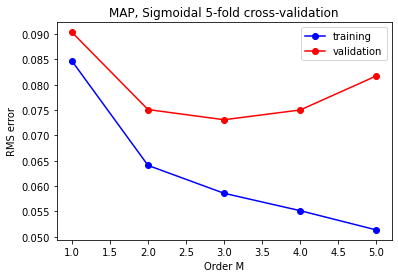

Order M =  1 , Avg training error: 0.0846991624281566 , Avg validation error: 0.09036689376965198
Order M =  2 , Avg training error: 0.06408060396170344 , Avg validation error: 0.07510092046755874
Order M =  3 , Avg training error: 0.05857210140028803 , Avg validation error: 0.07309489519399379
Order M =  4 , Avg training error: 0.05514056683364145 , Avg validation error: 0.07501844439281914
Order M =  5 , Avg training error: 0.05134198229367911 , Avg validation error: 0.08173555283648468


In [40]:
cross_train_error = []
cross_valid_error = []
for i in range(5):
  partial_valid_x = x[i*100:(i+1)*100, :]
  partial_valid_y = y[i*100:(i+1)*100, :]
  partial_train_x = np.concatenate( (x[:i*100, :], x[(i+1)*100:, :]), axis=0)
  partial_train_y = np.concatenate( (y[:i*100, :], y[(i+1)*100:, :]), axis=0)
  train_error_i = []
  valid_error_i = []
  for j in range(5):
    tmp_valid_x = calculate_basis(partial_valid_x, j+1)
    tmp_train_x = calculate_basis(partial_train_x, j+1)
    tmp_valid_x = sigmoidal(tmp_valid_x)
    tmp_train_x = sigmoidal(tmp_train_x)
    w_cross_valid = max_likelihood(tmp_train_x, partial_train_y)
    beta_inv = np.sum( np.power(np.dot(tmp_train_x, w_cross_valid)-train_y, 2) )/400
    w_cross_valid = max_a_posterior(tmp_train_x, partial_train_y, beta_inv)
    train_error_i.append(RMS_error(tmp_train_x, w_cross_valid, partial_train_y))
    valid_error_i.append(RMS_error(tmp_valid_x, w_cross_valid, partial_valid_y))
  cross_train_error.append(train_error_i)
  cross_valid_error.append(valid_error_i)

avg_train_error = np.mean(np.array(cross_train_error), axis=0)
avg_valid_error = np.mean(np.array(cross_valid_error), axis=0)

plt.plot(range(1,6), avg_train_error, '-bo', label='training')
plt.plot(range(1,6), avg_valid_error, '-ro', label='validation')
plt.title('MAP, Sigmoidal 5-fold cross-validation')
plt.xlabel('Order M')
plt.ylabel('RMS error')
plt.legend()
plt.show()

for i in range(1,6):
  print("Order M = ", i, ", Avg training error:", avg_train_error[i-1], ", Avg validation error:", avg_valid_error[i-1])